# Comparison of neural networks trained with and without DeepProbLog (DPL) for MNIST number recognition

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch import optim

import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader as TorchLoader
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

from zipfile import ZipFile
from io import BytesIO
from typing import Any, Dict
import time
import os
from IPython.display import Code

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

from network import MNIST_Net
import re
import sys

num_epochs = 1

## Dataset preparation

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

mnist_train = MNIST(root = 'data/', train = True, transform = transform)
mnist_test = MNIST(root = 'data/', train = False, transform = transform)
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


torch.Size([1, 28, 28]) 5


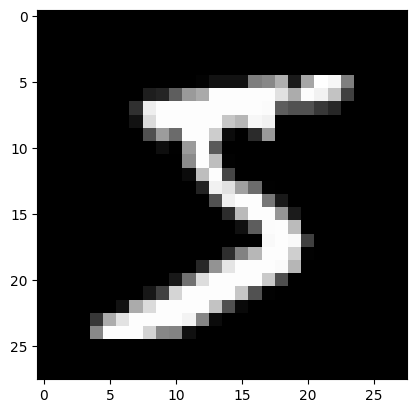

In [3]:
image_tensor, label = mnist_train[0]
print(image_tensor.shape, label)
plt.imshow(image_tensor[0], cmap = 'gray')

In [4]:
batch_size = 10
train_loader = TorchLoader(mnist_train, batch_size, shuffle = True)
test_loader = TorchLoader(mnist_test, batch_size, shuffle = False)

## Used network, imported from MNIST example provided with DeepProbLog

In [5]:
with open('network.py', 'r') as f:
    code = f.read()
Code(code, language='python')

import torch.nn as nn

class MNIST_Net(nn.Module):
    def __init__(self, N=10, with_softmax=True, size=16 * 4 * 4):
        super(MNIST_Net, self).__init__()
        self.with_softmax = with_softmax
        self.size = size
        if with_softmax:
            if N == 1:
                self.softmax = nn.Sigmoid()
            else:
                self.softmax = nn.Softmax(1)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2, 2),  # 6 24 24 -> 6 12 12
            nn.ReLU(True),
            nn.Conv2d(6, 16, 5),  # 6 12 12 -> 16 8 8
            nn.MaxPool2d(2, 2),  # 16 8 8 -> 16 4 4
            nn.ReLU(True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(size, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, N),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, self.size)
        x = self.classifier(x)
        if self.with_softmax:
            x = self.softmax(x)
        return x

# Number recognition

## Create and train model without DPL

In [6]:
network_base = MNIST_Net()
loss_func = CrossEntropyLoss()   

#### Define train and test functions

In [11]:
def train(num_epochs, network, loader):
    
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
            
    epoch_size = len(loader)
        
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        train_loss = 0
        train_accuracy = 0
        samples = 0
        
        network.train()
        for i, (batch_x, batch_y) in enumerate(loader):
            
            optimizer.zero_grad()           

            pred = network(batch_x)
            loss = loss_func(pred, batch_y.long())
              
            loss.backward()                      
            optimizer.step()      
            
            train_loss += loss.item() * batch_y.size(0)
            train_accuracy += (pred.max(1)[1] == batch_y).sum().item()
            samples += batch_y.size(0)
            
            if (i+1) % 500 == 0:
                print(f'Epoch: {epoch+1}, train loss: {(train_loss/samples):.4}, train_accuracy: {(train_accuracy/samples):.4}')         

        print(f'Epoch: {epoch+1}, time {(time.time()-epoch_start_time):.4}', end='')
        print(f', train loss: {(train_loss/samples):.4}, train_accuracy: {(train_accuracy/samples):.4}')
     
    
def test(network, loader, verbose=True):      
    with torch.no_grad():
        start_time = time.time()
        train_loss = 0
        train_accuracy = 0
        samples = 0
        network.eval()
        
        for i, (batch_x, batch_y) in enumerate(loader):
            pred = network(batch_x)
            loss = loss_func(pred, batch_y.long())     
            
            train_loss += loss.item() * batch_y.size(0)
            train_accuracy += (pred.max(1)[1] == batch_y).sum().item()
            samples += batch_y.size(0)
        
        if verbose:
            print(f'Time {(time.time()-start_time):.4}', end='')
            print(f', test loss: {(train_loss/samples):.4}, test accuracy: {(train_accuracy/samples):.4}')
        return round(train_accuracy/samples, 4)
   
def train_or_load(num_epochs, network, loader, path):
    if os.path.exists(path):
        network.load_state_dict(torch.load(path))
    else:
        train(num_epochs, network, loader)
        torch.save(network_base.state_dict(), path) 
        

#### Define confusion matrix functions

In [8]:
def show_conf_matrices(data, title, x_labels=None, y_labels=None):
    x_labels = [i for i in range(10)] if x_labels==None else x_labels
    y_labels = [i for i in range(10)] if y_labels==None else y_labels
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    
    show_conf_matrix(ax[0], x_labels, y_labels, data)
    show_conf_matrix_zero_diag(ax[1], x_labels, y_labels, data)
    
    fig.tight_layout()
    plt.show()
    
def get_conf_matrix(network, loader):
    pred = []
    true_y = []
    
    for batch_x, batch_y in loader:
        batch_x = network(batch_x)
        batch_x = batch_x.max(1)[1].numpy()
        batch_y = batch_y.data.numpy()
        
        pred.extend(batch_x)
        true_y.extend(batch_y)
        
    conf_matrix = confusion_matrix(true_y, pred)
    return conf_matrix
        
def show_conf_matrix(ax, x_labels, y_labels, data, title='Confusion Matrix'):

    im = ax.imshow(data)
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)

    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            text = ax.text(j, i, data[i, j], ha='center', va='center', color='w')
    ax.set_title(title)
    
def show_conf_matrix_zero_diag(ax, x_labels, y_labels, data):
    data_zero_diag = np.array([[data[j][i] if i != j else 0 for i in range(len(data))] for j in range(len(data[0]))])
    show_conf_matrix(ax, x_labels, y_labels, data_zero_diag, 'Confusion Matrix (only incorrect)')
        
def count_values(dataset):
    values_table = [0 for i in range(10)]
    for (x, label) in dataset:
        values_table[label] += 1
    return values_table

#### Training base model

In [9]:
train_or_load(num_epochs, network_base, train_loader, './snapshot_no_DPL/100.0.pt')

Epoch: 1, train loss: 1.77, train_accuracy: 0.6982
Epoch: 1, train loss: 1.665, train_accuracy: 0.8013
Epoch: 1, train loss: 1.62, train_accuracy: 0.8453
Epoch: 1, train loss: 1.596, train_accuracy: 0.8687
Epoch: 1, train loss: 1.581, train_accuracy: 0.8829
Epoch: 1, train loss: 1.57, train_accuracy: 0.8943
Epoch: 1, train loss: 1.561, train_accuracy: 0.9025
Epoch: 1, train loss: 1.555, train_accuracy: 0.9088
Epoch: 1, train loss: 1.549, train_accuracy: 0.9143
Epoch: 1, train loss: 1.544, train_accuracy: 0.919
Epoch: 1, train loss: 1.54, train_accuracy: 0.9227
Epoch: 1, train loss: 1.537, train_accuracy: 0.926
Epoch: 1, time 55.57, train loss: 1.537, train_accuracy: 0.926


#### Testing base model

In [10]:
test(network_base, test_loader)

Time 3.94, test loss: 1.501, test accuracy: 0.9595


0.9595

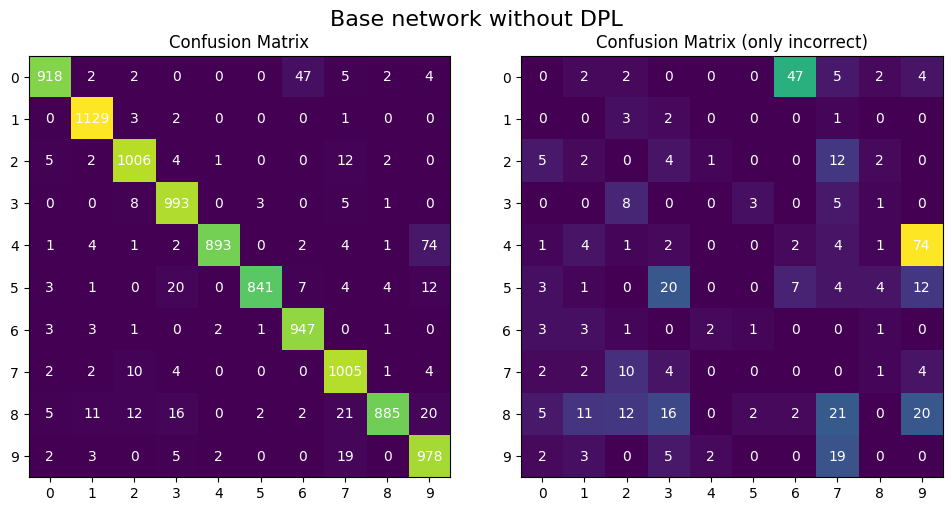

In [12]:
cm = get_conf_matrix(network_base, test_loader)
show_conf_matrices(cm, "Base network without DPL")

## Train model with DPL

In [13]:
class redirect_output(object):

    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [14]:
if not os.path.exists('snapshot/100.0.pth'):
    with redirect_output("snapshot/100.0_out.txt"):
        %run -i -t addition.py 100

#### Define function to load already trained DPL models 

In [15]:
def load_from_dpl(path):
    net = MNIST_Net()
    
    with ZipFile(path) as zipf:
        with zipf.open('mnist_net') as f:
            loaded: Dict[str, Any] = torch.load(BytesIO(f.read()))
            net.load_state_dict(loaded["model_state_dict"])
    return net

In [16]:
net_dpl = load_from_dpl('snapshot/100.0.pth')
net_dpl

MNIST_Net(
  (softmax): Softmax(dim=1)
  (encoder): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Test model with DPL

In [17]:
test(net_dpl, test_loader)

Time 6.066, test loss: 1.507, test accuracy: 0.9701


0.9701

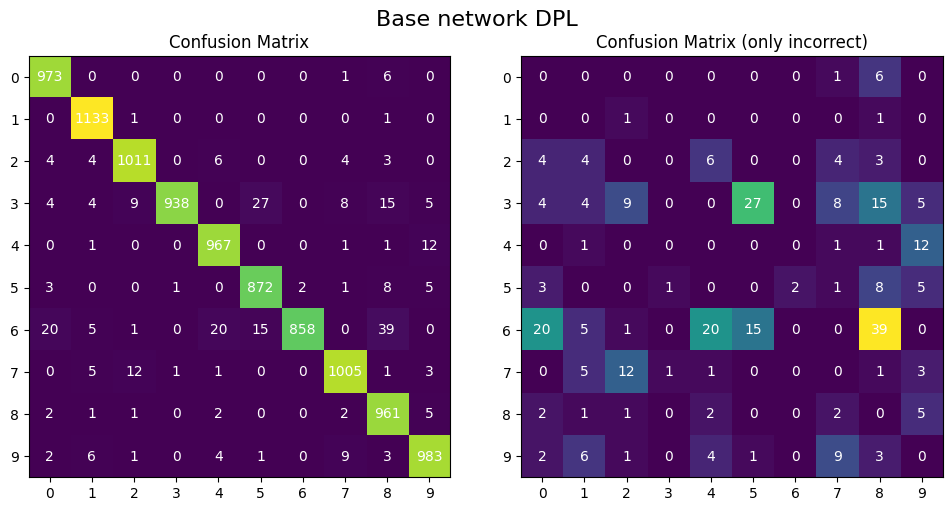

In [18]:
cm_dpl = get_conf_matrix(net_dpl, test_loader)
show_conf_matrices(cm_dpl, "Base network DPL")

## Comparison of models trained with reduced datasets 

In [19]:
mnist_to_reduce = MNIST(root = 'data/', train = True, transform = transform)

split_parts = [0.2, 0.02]
split_parts.append(1 - sum(split_parts))

reduced_datasets = random_split(mnist_to_reduce, split_parts, generator=torch.Generator().manual_seed(42))
mnist_reduced_10k = reduced_datasets[0]
mnist_reduced_1k = reduced_datasets[1]

In [20]:
network_base_reduced_10k = MNIST_Net()
network_base_reduced_1k = MNIST_Net()

In [21]:
batch_size = 10
num_epochs = 1
train_loader_10k = TorchLoader(mnist_reduced_10k, batch_size, shuffle = True)
train_loader_1k = TorchLoader(mnist_reduced_1k, batch_size, shuffle = True)
print('diffrent values in 10k set', count_values(mnist_reduced_10k))
print('diffrent values in 1k set', count_values(mnist_reduced_1k))

diffrent values in 10k set [1179, 1293, 1196, 1247, 1179, 1097, 1212, 1218, 1206, 1173]
diffrent values in 1k set [130, 143, 124, 106, 120, 106, 122, 115, 113, 121]


### Train and test dataset with 12k numers (without DPL)

In [22]:
train_or_load(num_epochs, network_base_reduced_10k, train_loader_10k, './snapshot_no_DPL/20.0.pt')

In [23]:
test(network_base_reduced_10k, test_loader)

Time 3.751, test loss: 1.534, test accuracy: 0.9309


0.9309

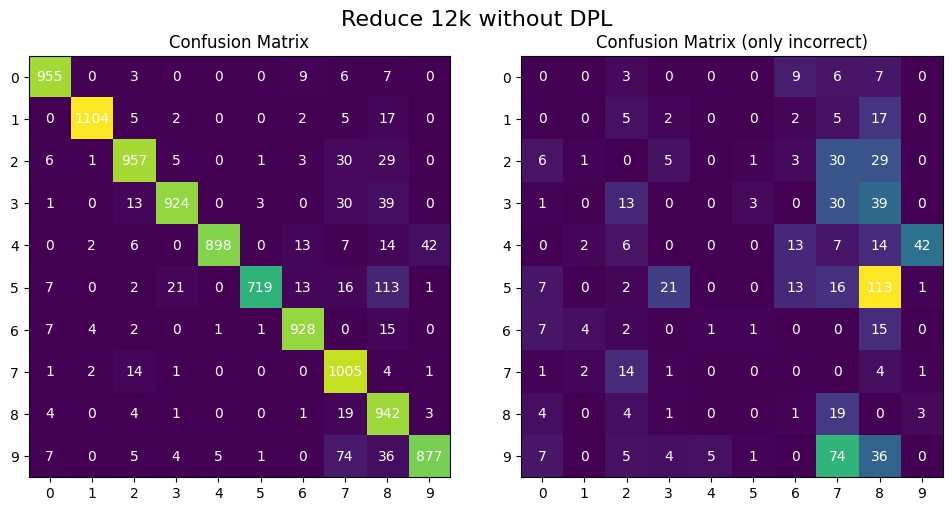

In [24]:
cm = get_conf_matrix(network_base_reduced_10k, test_loader)
show_conf_matrices(cm, "Reduce 12k without DPL")

### Train and test dataset with 1.2k numers (without DPL)

In [25]:
train_or_load(num_epochs, network_base_reduced_1k, train_loader_1k, './snapshot_no_DPL/2.0.pt')

In [26]:
test(network_base_reduced_1k, test_loader)

Time 3.731, test loss: 1.819, test accuracy: 0.6759


0.6759

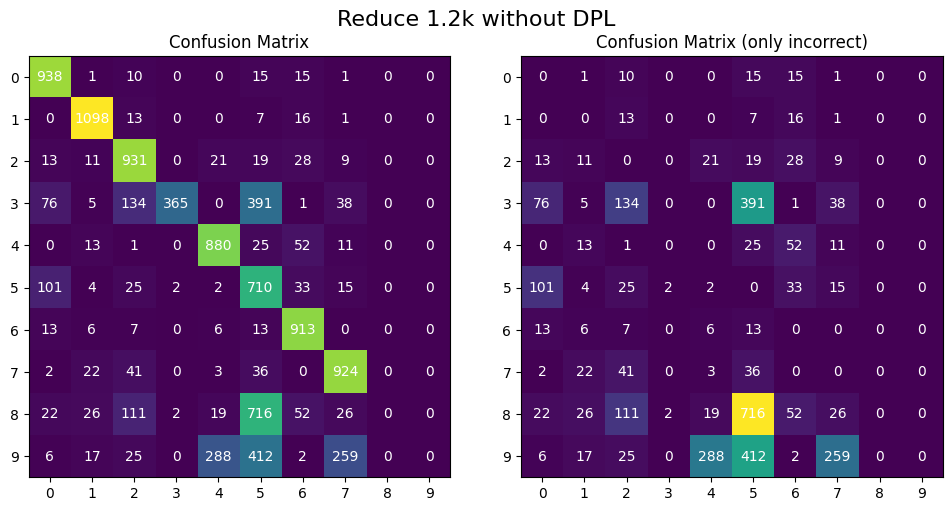

In [27]:
cm = get_conf_matrix(network_base_reduced_1k, test_loader)
show_conf_matrices(cm, "Reduce 1.2k without DPL")

### Train and test dataset with 12k numers (DPL)

In [28]:
if not os.path.exists('snapshot/20.0.pth'):
    with redirect_output("snapshot/20.0_out.txt"):
        %run -i -t addition.py 20

In [29]:
net_dpl_reduce_10k = load_from_dpl('snapshot/20.0.pth')
test(net_dpl_reduce_10k, test_loader)

Time 9.22, test loss: 1.552, test accuracy: 0.9341


0.9341

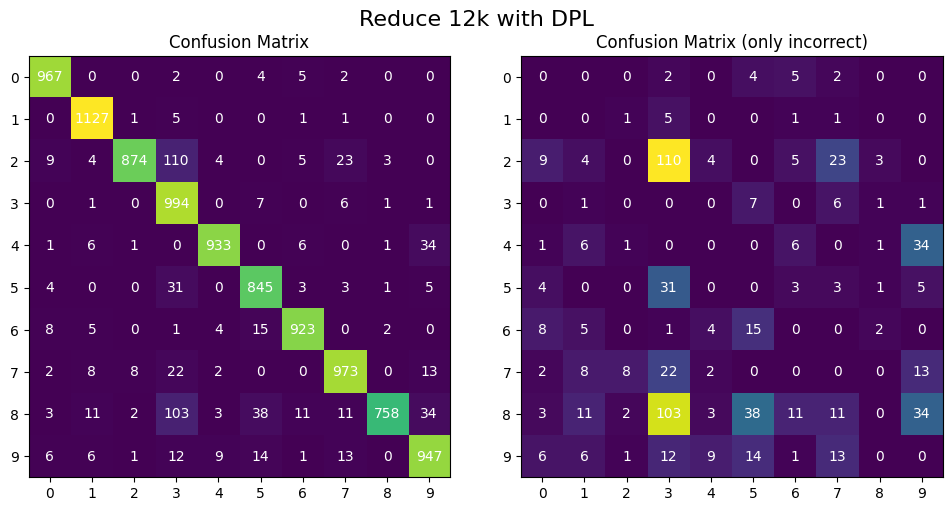

In [30]:
cm = get_conf_matrix(net_dpl_reduce_10k, test_loader)
show_conf_matrices(cm, "Reduce 12k with DPL")

### Train and test dataset with 1.2k numers (DPL)

In [31]:
if not os.path.exists('snapshot/2.0.pth'):
    with redirect_output("snapshot/2.0_out.txt"):
        %run -i -t addition.py 2

In [32]:
net_dpl_reduce_1k = load_from_dpl('snapshot/2.0.pth')
test(net_dpl_reduce_1k, test_loader)

Time 7.326, test loss: 2.286, test accuracy: 0.1835


0.1835

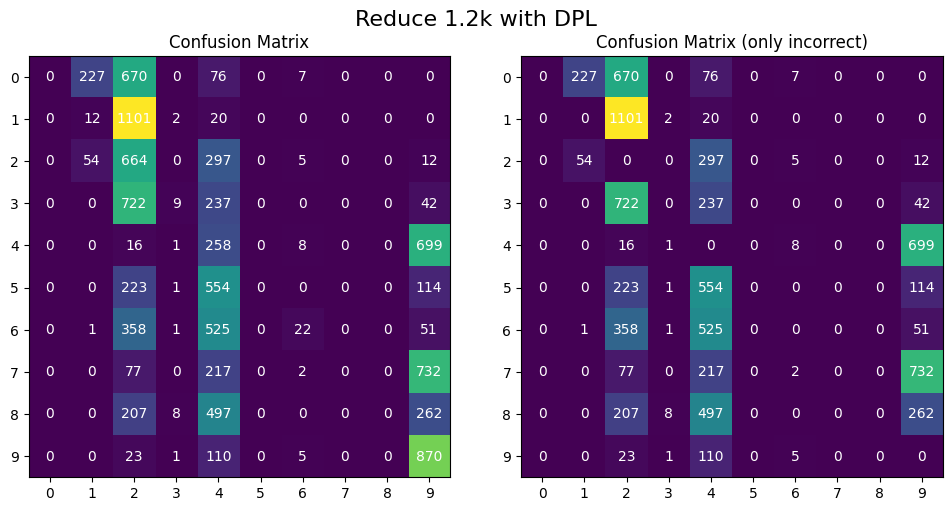

In [33]:
cm = get_conf_matrix(net_dpl_reduce_1k, test_loader)
show_conf_matrices(cm, "Reduce 1.2k with DPL")

## Test DPL models in addition 

In [34]:
def get_test_values_from_txt(file, only_accuracy=False):
    with open(file) as f:
        lines = list(f.readlines())
        
    accuracy = 'Accuracy:'
    to_add = False
    x = []
    y = []
    matrix = []
    
    for i in range(len(lines)):
        lines[i] = lines[i].strip()
        
        if accuracy in lines[i]:
            to_add = False
            accuracy = lines[i]
            
        if to_add:
            matrix.append(lines[i])
            
        if 'Actual' in lines[i]:
            to_add = True
    
    accuracy = float(re.findall("\d+\.\d+", accuracy)[0])
    if only_accuracy:
        return accuracy
    
    x = matrix.pop(0)
    x = [int(i) for i in re.findall("\d+", x)]

    for i in range(len(matrix)):
        row = [int(i) for i in re.findall("\d+", matrix[i])]
        y.append(row[0])
        matrix[i] = row[1:]
    
    return accuracy, x, y, matrix


def show_conf_matrix_from_txt(file, title='Confusion Matrix'):
    acc, x, y, m = get_test_values_from_txt(file)
        
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(m)

    ax.set_xticks(np.arange(len(x)), labels=x)
    ax.set_yticks(np.arange(len(y)), labels=y)

    for i in range(len(x)):
        for j in range(len(y)):
            text = ax.text(j, i, m[i][j], ha='center', va='center', color='w')
            
    fig.tight_layout()
    plt.title(title, fontsize=14)
    plt.xlabel('Actuals', fontsize=14)
    plt.ylabel('Predictions', fontsize=14)
    plt.show()
    
    print('Accuracy: ', acc)
    
def get_accuracy(file):
    return get_test_values_from_txt(file, True)

### MNIST model 

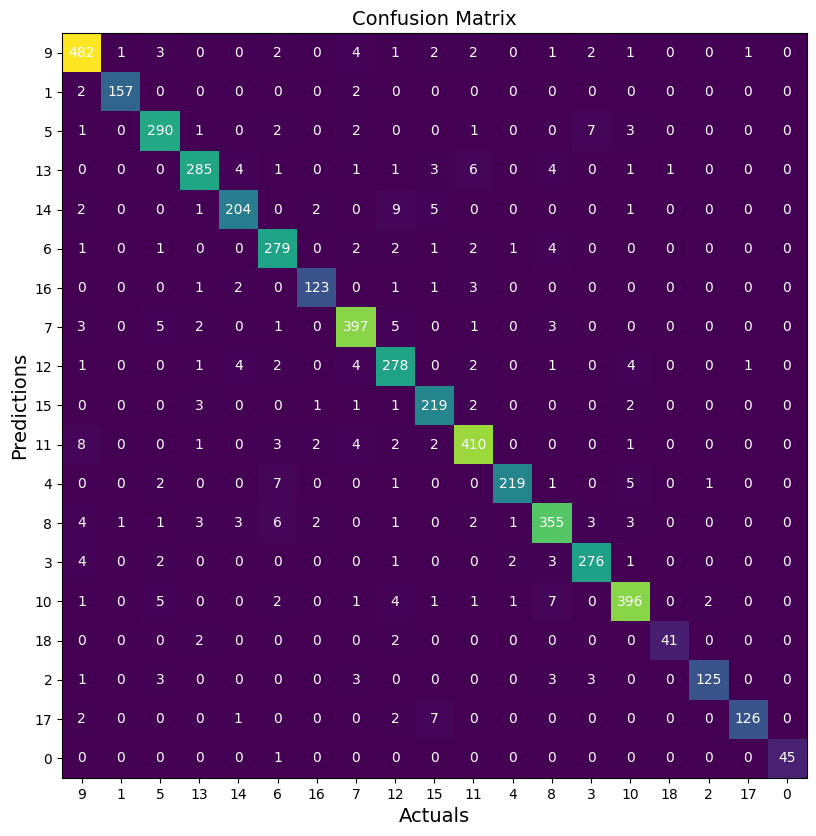

Accuracy:  0.9414


In [35]:
show_conf_matrix_from_txt('snapshot/100.0_out.txt')

### 12k MNIST model 

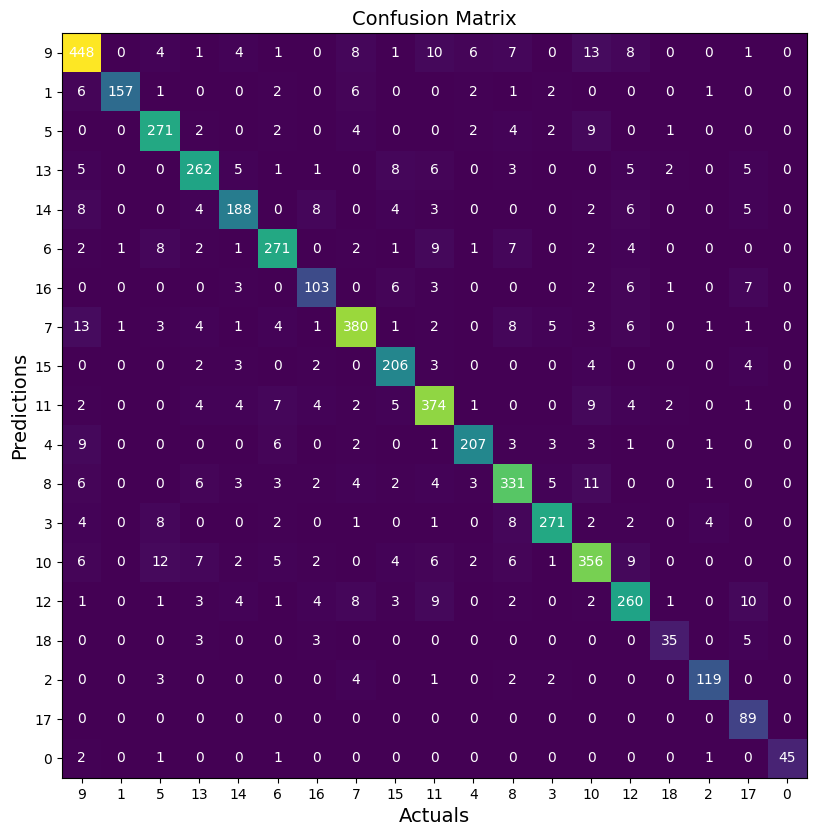

Accuracy:  0.8746


In [36]:
show_conf_matrix_from_txt('snapshot/20.0_out.txt')

### 1.2k MNIST model 

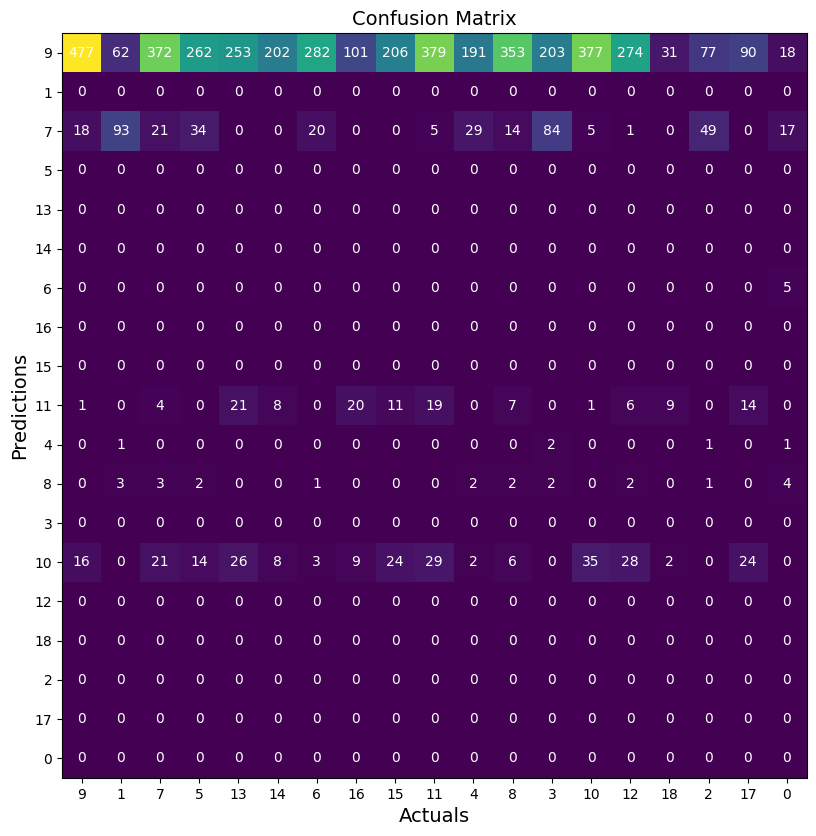

Accuracy:  0.1108


In [37]:
show_conf_matrix_from_txt('snapshot/2.0_out.txt')

## Test models in addition (without DPL)

In [38]:
def test_addition(network, loader, verbose=True):
            
    with torch.no_grad():
        start_time = time.time()
        train_accuracy = 0
        samples = 0
        network.eval()
        
        for i, (batch_x, batch_y) in enumerate(loader):
            pred = network(batch_x)
            pred = [sum(pred.max(1)[1])]
            pred = torch.FloatTensor(pred)
            batch_y = [sum(batch_y.long())]
            batch_y = torch.FloatTensor(batch_y)

            train_accuracy += (pred == batch_y).sum().item()
            samples += batch_y.size(0)
        
        if verbose:
            print(f'Time {(time.time()-start_time):.4}', end='')
            print(f', Test accuracy: {(train_accuracy/samples):.4}')
        return round(train_accuracy/samples, 4)


In [39]:
def get_conf_matrix_for_addition(network, loader):
    pred = []
    true_y = []
    
    for batch_x, batch_y in loader:
        batch_x = network(batch_x)
        batch_x = [sum(batch_x.max(1)[1])]
        batch_y = [sum(batch_y)]
         
        pred.extend(batch_x)
        true_y.extend(batch_y)
        
    conf_matrix = confusion_matrix(true_y, pred)
    return conf_matrix

def show_matrix_addition(data, title, label_x, label_y):
        
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(data)

    ax.set_xticks(np.arange(len(label_x)), labels=label_x)
    ax.set_yticks(np.arange(len(label_y)), labels=label_y)

    for i in range(len(label_x)):
        for j in range(len(label_y)):
            text = ax.text(j, i, data[i][j], ha='center', va='center', color='w')
            
    fig.tight_layout()
    plt.title(title, fontsize=14)
    plt.xlabel('Actuals', fontsize=14)
    plt.ylabel('Predictions', fontsize=14)
    plt.show()

### Base model full MNIST

In [40]:
test_addition_loader = TorchLoader(mnist_test, 2, shuffle = False)
test_addition(network_base, test_addition_loader)

Time 12.64, Test accuracy: 0.9224


0.9224

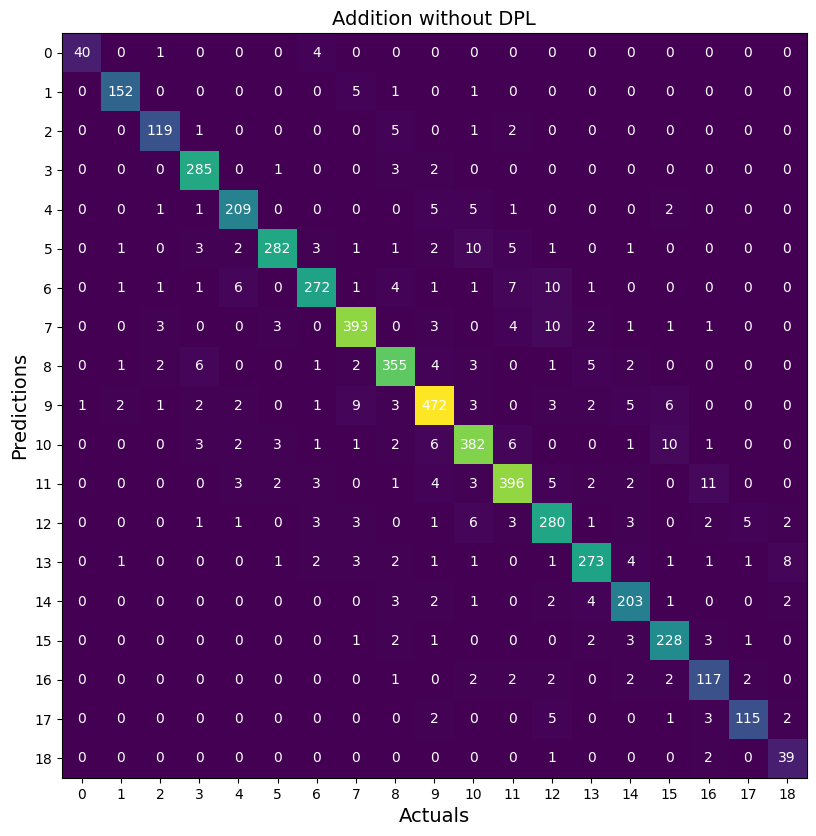

In [41]:
label_x = [i for i in range(0, 19)]
label_y = [i for i in range(0, 19)]
cm = get_conf_matrix_for_addition(network_base, test_addition_loader)
show_matrix_addition(cm, "Addition without DPL", label_x, label_y)

### 12k MNIST model 

Time 6.893, Test accuracy: 0.8684


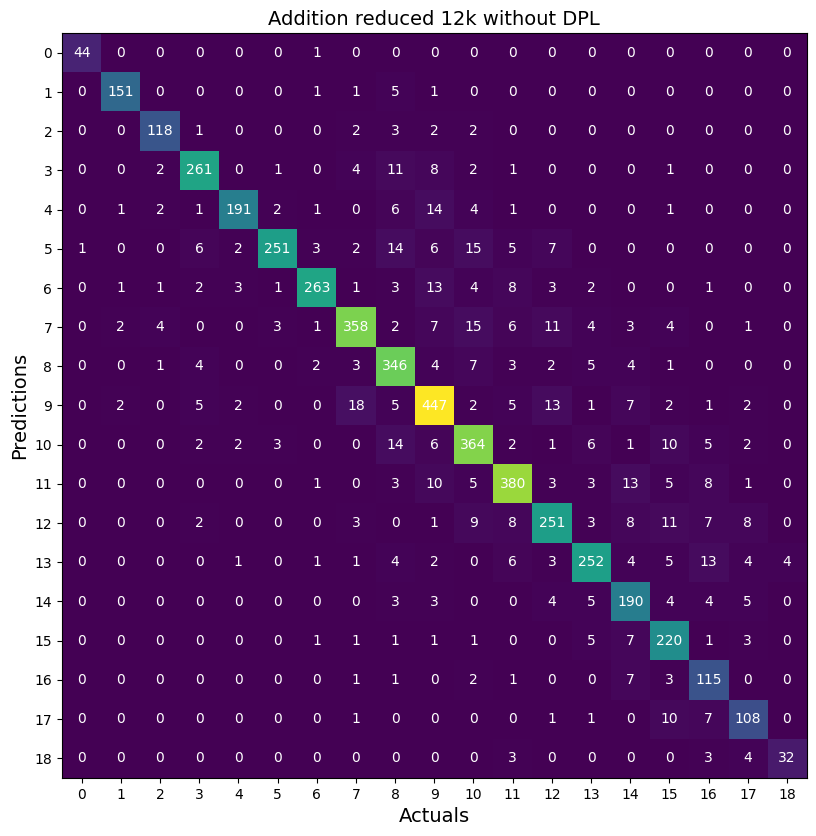

In [42]:
test_addition(network_base_reduced_10k, test_addition_loader)
cm = get_conf_matrix_for_addition(network_base_reduced_10k, test_addition_loader)
show_matrix_addition(cm, "Addition reduced 12k without DPL", label_x, label_y)

### 1.2k MNIST model 

Time 10.97, Test accuracy: 0.4682


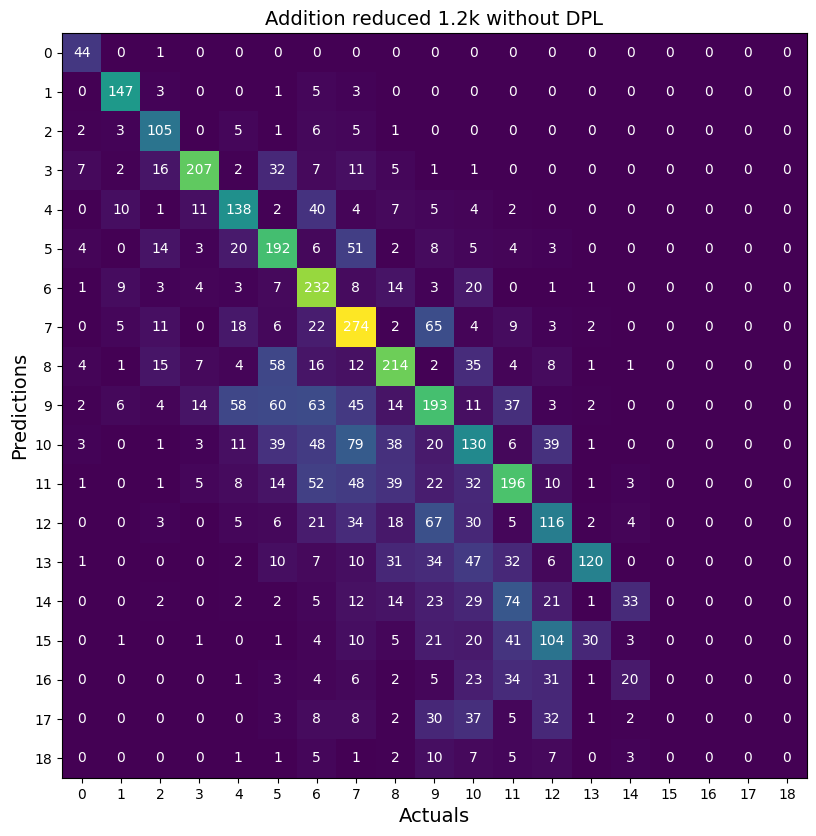

In [43]:
test_addition(network_base_reduced_1k, test_addition_loader)
cm = get_conf_matrix_for_addition(network_base_reduced_1k, test_addition_loader)
show_matrix_addition(cm, "Addition reduced 1.2k without DPL", label_x, label_y)

# Comparison of models accuracy depending on datasets sizes

In [44]:
datasets_sizes = [100, 25, 20, 15, 10, 8, 6, 4, 2, 1]

In [45]:
for size in datasets_sizes:
    print(size)
    path = './snapshot/' + str(float(size)) + '.pth'
    path_out = './snapshot/' + str(float(size)) + '_out.txt'
    if not os.path.exists(path):
        with redirect_output(path_out):
            %run -i -t addition.py {size}

100
25
20
15
10
8
6
4
2
1


In [46]:
test_accuracy_DPL = []
for size in datasets_sizes:
    path = './snapshot/' + str(float(size)) + '.pth'
    net = MNIST_Net()
    net = load_from_dpl(path)
    test_accuracy_DPL.append(test(net, test_loader, False))

In [47]:
test_accuracy_DPL

[0.9701, 0.9585, 0.9341, 0.931, 0.8376, 0.5224, 0.4077, 0.41, 0.1835, 0.0892]

In [48]:
mnist_to_reduce = MNIST(root = 'data/', train = True, transform = transform)

def get_reduce_set(data, size):
    size = size/100
    if size == 1:
        reduced_datasets = [data]
    else:
        reduced_datasets = random_split(data, [size, 1-size], generator=torch.Generator().manual_seed(42))
    return reduced_datasets[0]
    
def train_reduced_no_DPL(data, size):
    net = MNIST_Net()
    data = get_reduce_set(data, size)
    path = './snapshot_no_DPL/' + str(float(size)) + '.pt'
    loader = TorchLoader(data, batch_size, shuffle = True)
    train_or_load(num_epochs, net, loader, path)
#     train_or_load(num_epochs, network_base_reduced_1k, train_loader_1k, './snapshot_no_DPL/2.pt')

In [49]:
mnist_to_reduce = MNIST(root = 'data/', train = True, transform = transform)

def _train(num_epochs, network, loader):
    
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
            
    epoch_size = len(loader)
        
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        train_loss = 0
        train_accuracy = 0
        samples = 0
        
        network.train()
        for i, (batch_x, batch_y) in enumerate(loader):
            
            optimizer.zero_grad()           

            pred = network(batch_x)
            loss = loss_func(pred, batch_y.long())
              
            loss.backward()                      
            optimizer.step()      
            
            train_loss += loss.item() * batch_y.size(0)
            train_accuracy += (pred.max(1)[1] == batch_y).sum().item()
            samples += batch_y.size(0)
            
            if (i+1) % 500 == 0:
                print(f'Epoch: {epoch+1}, train loss: {(train_loss/samples):.4}, train_accuracy: {(train_accuracy/samples):.4}')         

        print(f'Epoch: {epoch+1}, time {(time.time()-epoch_start_time):.4}', end='')
        print(f', train loss: {(train_loss/samples):.4}, train_accuracy: {(train_accuracy/samples):.4}')

def get_reduce_set(data, size):
    size = size/100
    if size == 1:
        reduced_datasets = [data]
    else:
        reduced_datasets = random_split(data, [size, 1-size], generator=torch.Generator().manual_seed(42))
    return reduced_datasets[0]

In [50]:
for size in datasets_sizes:
    print(size)
    _net = MNIST_Net()    
    data = get_reduce_set(mnist_to_reduce, size)
    path = './snapshot_no_DPL/' + str(float(size)) + '.pt'
    loader = TorchLoader(data, batch_size, shuffle = True)
    
    if os.path.exists(path):
        _net.load_state_dict(torch.load(path))
    else:
        _train(num_epochs, _net, loader)
        torch.save(_net.state_dict(), path) 

100
25
20
15
10
8
6
4
2
1


In [51]:
test_accuracy_without_DPL = []
for size in datasets_sizes:
    path = './snapshot_no_DPL/' + str(float(size)) + '.pt'
    _net = MNIST_Net()
    _net.load_state_dict(torch.load(path))
    test_accuracy_without_DPL.append(test(_net, test_loader, False))

In [52]:
test_accuracy_without_DPL

[0.9595,
 0.8624,
 0.9309,
 0.9098,
 0.8164,
 0.8866,
 0.8718,
 0.7002,
 0.6759,
 0.3464]

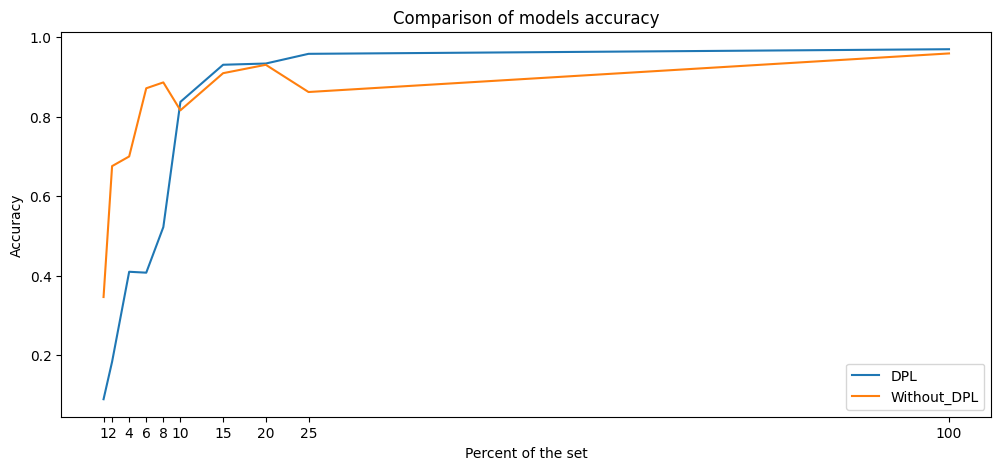

In [53]:
plt.figure(figsize=(12,5))
plt.plot(np.array(datasets_sizes), np.array(test_accuracy_DPL), label='DPL')
plt.plot(np.array(datasets_sizes), np.array(test_accuracy_without_DPL), label='Without_DPL')

plt.title("Comparison of models accuracy")

plt.xlabel("Percent of the set")
plt.ylabel("Accuracy")

plt.xticks(datasets_sizes)

plt.legend(loc="lower right")

plt.show()

In [54]:
test_accuracy_DPL_addition = []
for size in datasets_sizes:
    path = './snapshot/' + str(float(size)) + '_out.txt'
    test_accuracy_DPL_addition.append(get_accuracy(path))

In [55]:
test_accuracy_DPL_addition

[0.9414, 0.9196, 0.8746, 0.8672, 0.7012, 0.2668, 0.2354, 0.237, 0.1108, 0.1024]

In [56]:
test_accuracy_without_DPL_addition = []
for size in datasets_sizes:
    path = './snapshot_no_DPL/' + str(float(size)) + '.pt'
    _net = MNIST_Net()
    _net.load_state_dict(torch.load(path))
    test_accuracy_without_DPL_addition.append(test_addition(_net, test_addition_loader, False))

In [57]:
test_accuracy_without_DPL_addition

[0.9224, 0.743, 0.8684, 0.8284, 0.671, 0.789, 0.766, 0.494, 0.4682, 0.1412]

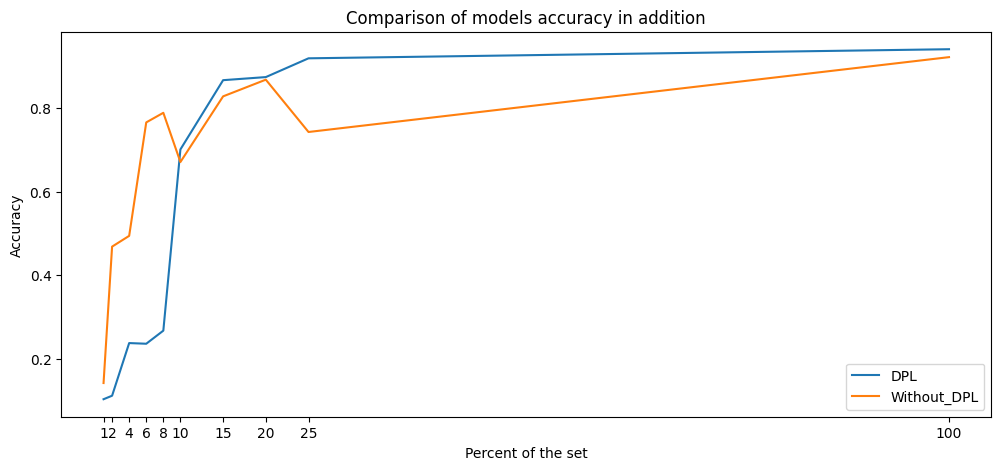

In [58]:
plt.figure(figsize=(12,5))
plt.plot(np.array(datasets_sizes), np.array(test_accuracy_DPL_addition), label='DPL')
plt.plot(np.array(datasets_sizes), np.array(test_accuracy_without_DPL_addition), label='Without_DPL')

plt.title("Comparison of models accuracy in addition")

plt.xlabel("Percent of the set")
plt.ylabel("Accuracy")

plt.xticks(datasets_sizes)

plt.legend(loc="lower right")

plt.show()